# preproc

In [ ]:
import numpy as np

In [ ]:
def preprocess_image(img):
    return np.where(img >= 0.8, img, 0.0)

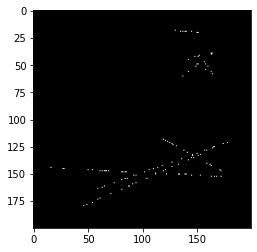

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(preprocess_image(make_data(8)[0]), cmap="gray")

# model

In [128]:
from helpers import make_data, score_iou

import torch
import numpy as np
import pytorch_lightning as pl
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset


class SpaceshipDataset(Dataset):
    def __init__(self, N, **kwargs):
        self.N = N
        self.kwargs = kwargs

    def __getitem__(self, idx):
        return make_data(**self.kwargs)

    def __len__(self):
        return self.N


class DataModule(pl.LightningDataModule):
    def __init__(self, n_train_examples, n_val_examples, batch_size):
        super().__init__()
        self.n_train_examples = n_train_examples
        self.n_val_examples = n_val_examples
        self.batch_size = batch_size

    def setup(self, stage):
        if stage == "fit":
            self.train_dataset = SpaceshipDataset(
                self.n_train_examples, has_spaceship=True
            )
            self.val_dataset = SpaceshipDataset(self.n_val_examples)
        else:
            self.test_dataset = SpaceshipDataset(self.n_val_examples)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1)


class Model(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.model = self.init_model()
        self.criterion = torch.nn.MSELoss()
        self.lr = lr

    def init_model(self):
        model = torch.nn.Sequential()

        conv_layers_params = [
            (8, 11),
            (16, 9),
            (32, 7),
            (64, 5),
            (128, 3),
            (256, 3),
            (512, 3),
        ]
        in_channels = 1
        for i, (nfilters, k) in enumerate(conv_layers_params):
            model.add_module(
                f"conv_{i}",
                torch.nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=nfilters,
                    kernel_size=k,
                    bias=False,
                    padding=(k - 1) // 2,  # same padding, stride and dilation must be 1
                ),
            )
            model.add_module(
                f"bn_{i}", torch.nn.BatchNorm2d(nfilters, affine=True, momentum=0.05)
            )
            model.add_module(f"relu_{i}", torch.nn.ReLU())
            model.add_module(f"pool_{i}", torch.nn.MaxPool2d(2, 2))
            in_channels = nfilters

        model.add_module("flatten", torch.nn.Flatten())
        model.add_module("linear", torch.nn.Linear(512, 5))

        return model

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        x = x.unsqueeze(1).float()
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self.forward(x)
        loss = self.criterion(outputs, y.float())
        self.log("train_loss", loss.item() / x.size(0))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self.forward(x)
        # val_loss = self.criterion(outputs, y.float())
        ious = np.asarray(
            [
                score_iou(pred.cpu().numpy(), label.cpu().numpy())
                for pred, label in zip(outputs, y)
            ],
            dtype="float",
        )
        ious = ious[~np.isnan(ious)]  # remove true negatives

        metrics = {
            # "val_loss": val_loss.item() / x.size(0),
            "mean_iou": ious.mean().item(),
            "score": (ious > 0.7).mean().item(),
        }
        for k, v in metrics.items():
            self.log(k, v)

        return outputs, metrics

    def test_step(self, *args, **kwargs):
        return self.validation_step(*args, **kwargs)


# if __name__ == "__main__":
#     dm = DataModule(32000, 1024, 32)
#     model = Model()
#     trainer = pl.Trainer(max_epochs=1, fast_dev_run=True, gpus=1)
#     trainer.fit(model, dm)
#     print(trainer.test(model, DataLoader(SpaceshipDataset(1000)))[1]["score"])


# run

In [159]:
dm = DataModule(32000, 1024, 32)
model = Model()
model.cuda()

Model(
  (model): Sequential(
    (conv_0): Conv2d(1, 8, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5), bias=False)
    (bn_0): BatchNorm2d(8, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (relu_0): ReLU()
    (pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_1): Conv2d(8, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
    (bn_1): BatchNorm2d(16, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (relu_1): ReLU()
    (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (relu_2): ReLU()
    (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=Fa

In [160]:
from torchsummary import summary
# print(model)
summary(model, (200, 200), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 200, 200]             968
       BatchNorm2d-2          [-1, 8, 200, 200]              16
              ReLU-3          [-1, 8, 200, 200]               0
         MaxPool2d-4          [-1, 8, 100, 100]               0
            Conv2d-5         [-1, 16, 100, 100]          10,368
       BatchNorm2d-6         [-1, 16, 100, 100]              32
              ReLU-7         [-1, 16, 100, 100]               0
         MaxPool2d-8           [-1, 16, 50, 50]               0
            Conv2d-9           [-1, 32, 50, 50]          25,088
      BatchNorm2d-10           [-1, 32, 50, 50]              64
             ReLU-11           [-1, 32, 50, 50]               0
        MaxPool2d-12           [-1, 32, 25, 25]               0
           Conv2d-13           [-1, 64, 25, 25]          51,200
      BatchNorm2d-14           [-1, 64,

In [161]:
trainer = pl.Trainer(auto_lr_find=True, gpus=1)
trainer.tune(model, dm)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | Sequential | 1.6 M 
1 | criterion | MSELoss    | 0     


Learning rate set to 0.012022644346174132


In [162]:
model.lr

0.012022644346174132

# train

In [163]:
trainer = pl.Trainer(
    max_epochs=30,
    # fast_dev_run=True,
    val_check_interval=0.25,
    limit_train_batches=1,
    limit_val_batches=1,
    gpus=1,
    progress_bar_refresh_rate=20
)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | Sequential | 1.6 M 
1 | criterion | MSELoss    | 0     


1

In [164]:
trainer.test(model)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_iou': tensor(0.0137),
 'score': tensor(0.),
 'train_loss': 35.19796371459961,
 'val_loss': tensor(nan)}
--------------------------------------------------------------------------------



[{'mean_iou': 0.013727020472288132,
  'score': 0.0,
  'train_loss': 35.19796371459961,
  'val_loss': nan}]

In [ ]:
# !rm -rf lightning_logs/

In [135]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir lightning_logs/